In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

%matplotlib inline

In [2]:
from utils import adjust_sar_contrast, compute_building_score, plot_images

sys.path.append('..')
from spacenet6_model.configs.defaults import get_default_config
from spacenet6_model.datasets.spacenet6 import SpaceNet6Dataset
from spacenet6_model.models import get_model
from spacenet6_model.transforms import get_augmentation, get_preprocess

In [3]:
# set hyper parameters and path to model weight
exp = 'exp_0064'
config_path = f'/logs/{exp}/config.yml'
weight_path = f'/weights/{exp}/model_best.pth'

# select device to which the model is loaded
cuda = False
if cuda:
    device = 'cuda'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    device = 'cpu'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
config = get_default_config()

# overwtite from the config file
config.merge_from_file(config_path)

# overwrite model weight and device
config.MODEL.WEIGHT = weight_path
config.MODEL.DEVICE = device

config.freeze()
print(config)

DATALOADER:
  TRAIN_BATCH_SIZE: 24
  TRAIN_NUM_WORKERS: 8
  TRAIN_SHUFFLE: True
  VAL_BATCH_SIZE: 16
  VAL_NUM_WORKERS: 8
EVAL:
  MAIN_METRIC: iou/building_footprint
  METRICS: ['iou']
EXP_ID: 64
INPUT:
  BUILDING_DIR: /data/spacenet6/footprint_boundary_mask/v_01/labels
  CLASSES: ['building_footprint', 'building_boundary']
  IMAGE_DIR: /data/spacenet6/spacenet6/train
  IMAGE_TYPE: SAR-Intensity
  MEAN_STD_DIR: /data/spacenet6/image_mean_std/
  SAR_ORIENTATION: /data/spacenet6/spacenet6/train/SummaryData/SAR_orientations.txt
  TRAIN_VAL_SPLIT_DIR: /data/spacenet6/split
  TRAIN_VAL_SPLIT_ID: 3
LOG_ROOT: /logs
MODEL:
  ACTIVATION: sigmoid
  ARCHITECTURE: unet
  BACKBONE: efficientnet-b5
  DEVICE: cpu
  ENCODER_PRETRAINED_FROM: imagenet
  IN_CHANNELS: 4
  WEIGHT: /weights/exp_0064/model_best.pth
SOLVER:
  EPOCHS: 260
  FOCAL_LOSS_GAMMA: 2.0
  LOSSES: ['dice', 'bce']
  LOSS_WEIGHTS: [1.0, 1.0]
  LR: 0.0001
  LR_ANNEALING_ETA_MIN: 0.0
  LR_ANNEALING_T_MAX: 260
  LR_MULTISTEP_GAMMA: 0.1
  LR

In [5]:
split_id = config.INPUT.TRAIN_VAL_SPLIT_ID
val_list = os.path.join(
    config.INPUT.TRAIN_VAL_SPLIT_DIR,
    f'val_{split_id}.json'
)
preprocessing = get_preprocess(config)
augmentation = get_augmentation(config, is_train=False)

val_dataset = SpaceNet6Dataset(
    config,
    val_list,
    augmentation=augmentation,
    preprocessing=preprocessing,
)

val_dataset_vis = SpaceNet6Dataset(
    config,
    val_list,
    augmentation=augmentation,
    preprocessing=None,
)

channel_footprint = val_dataset.mask_channel_of('building_footprint')
channel_boundary = val_dataset.mask_channel_of('building_boundary')

In [6]:
model = get_model(config)
model.eval();

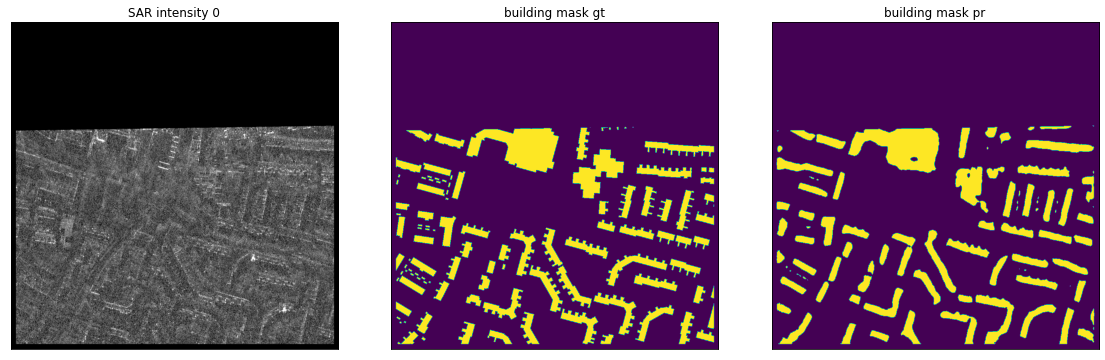

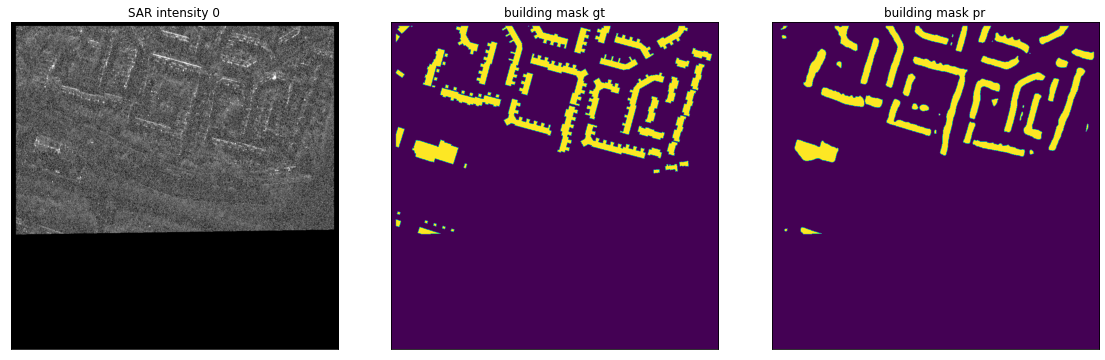

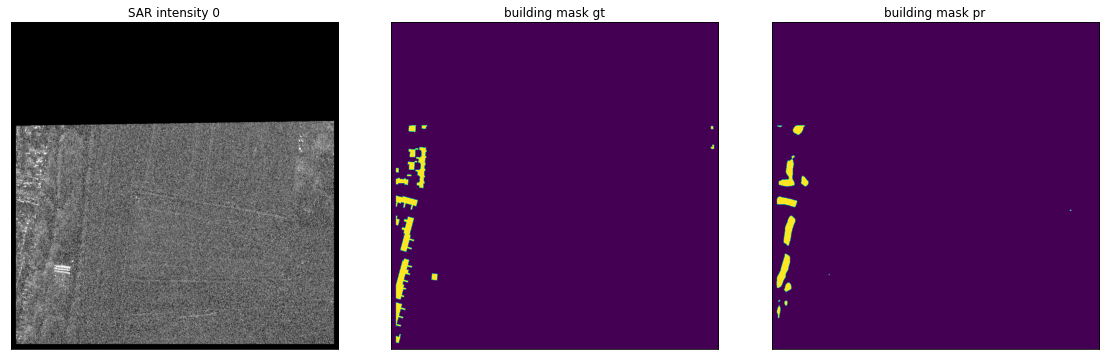

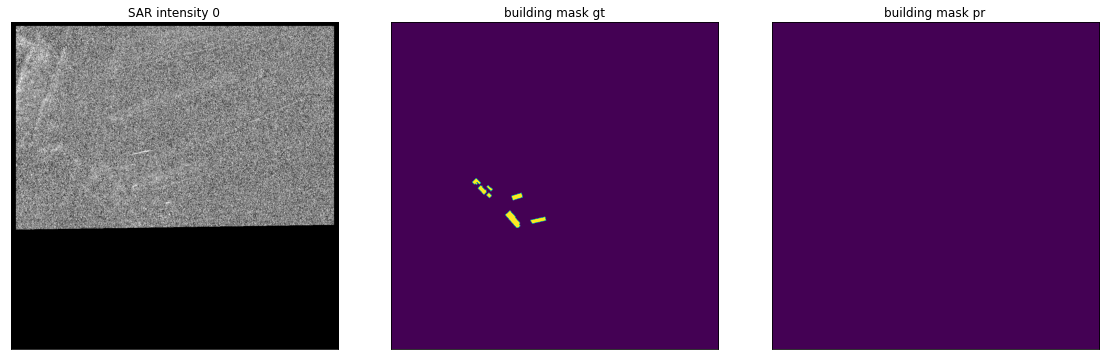

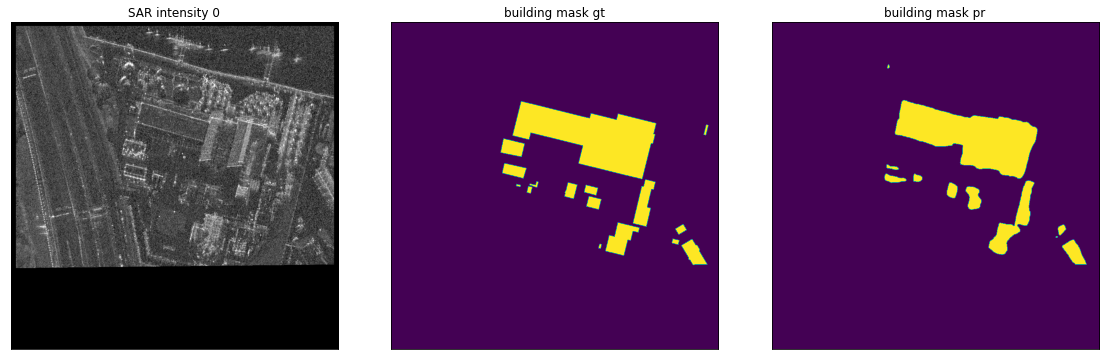

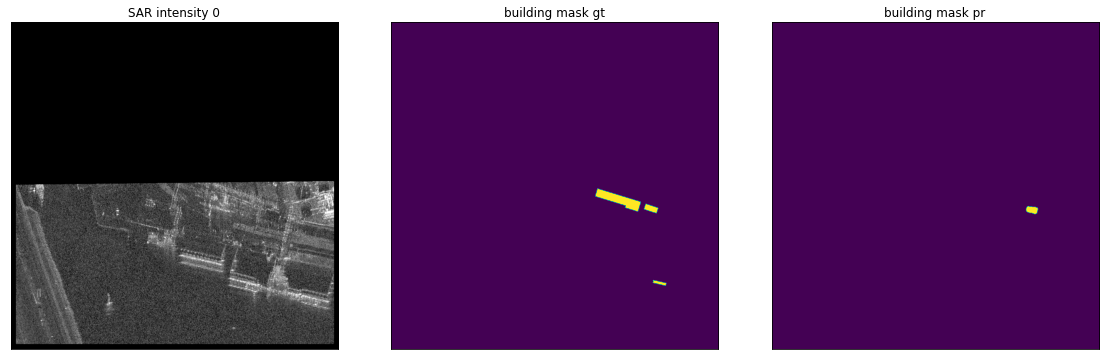

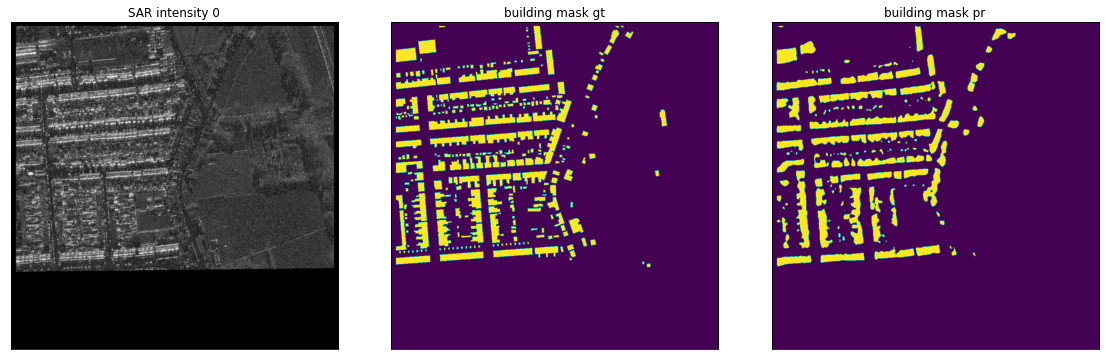

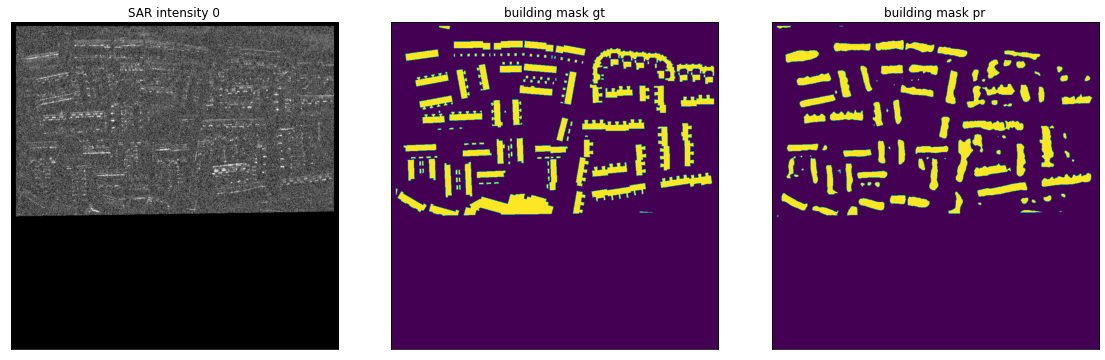

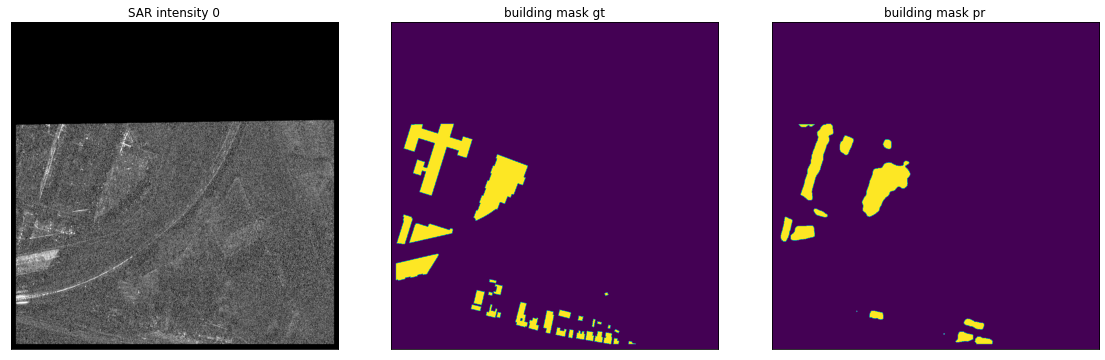

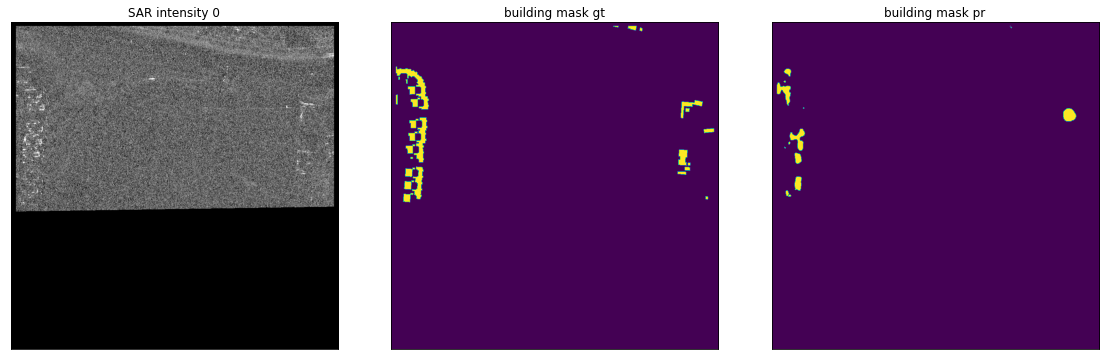

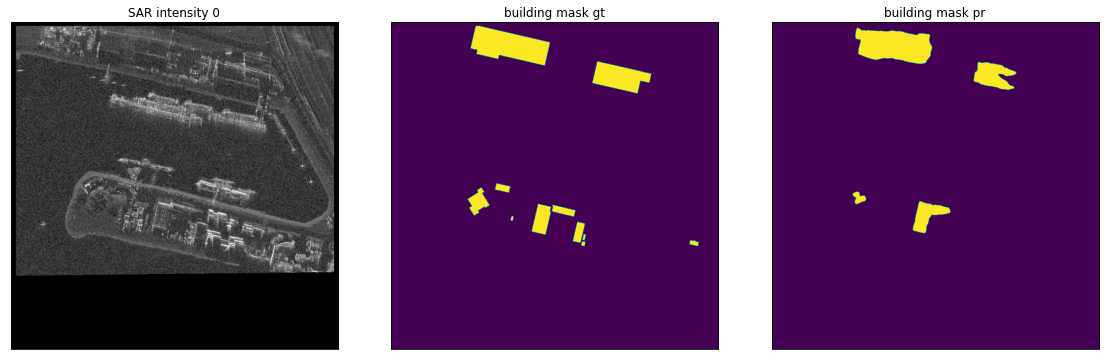

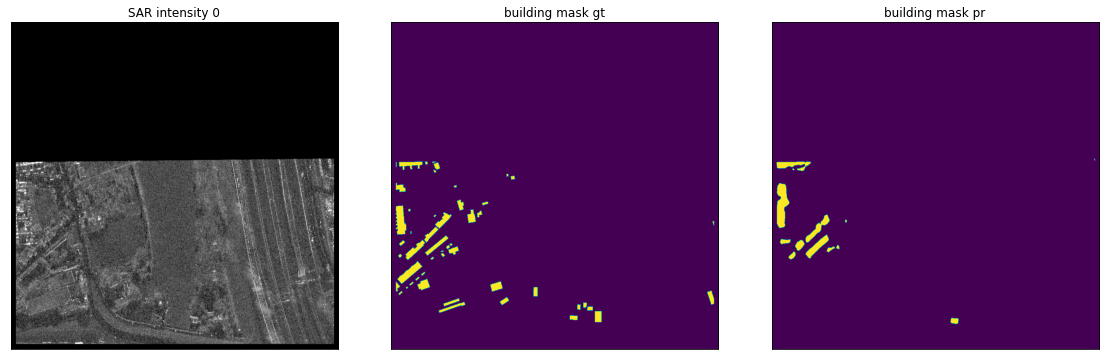

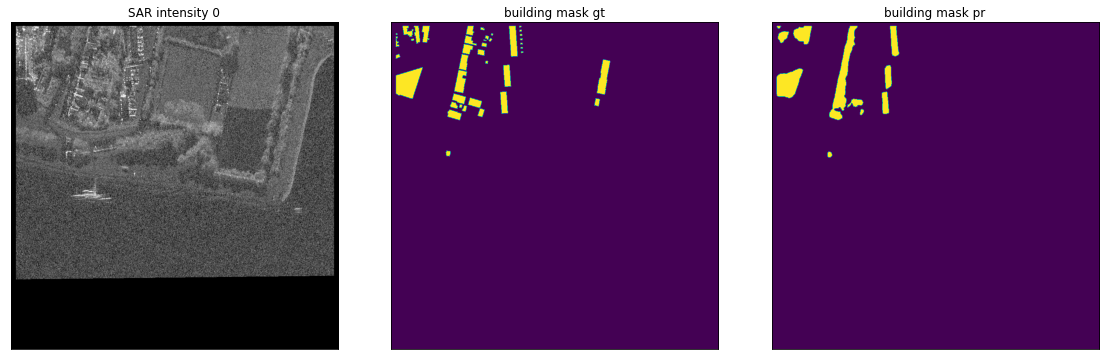

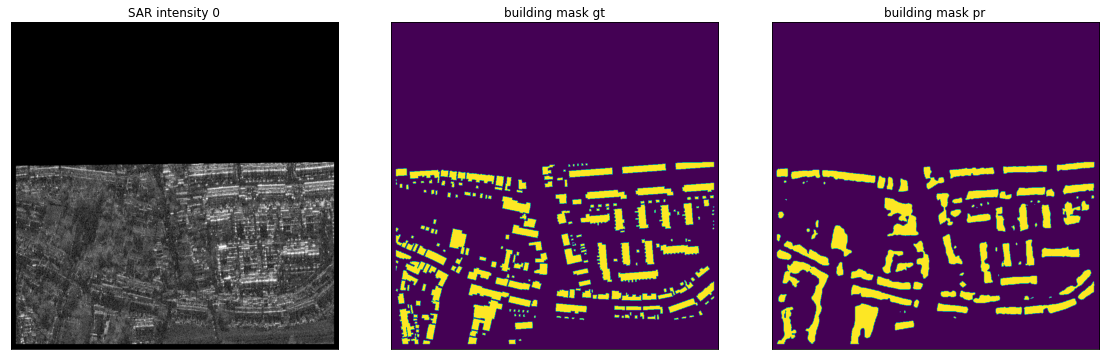

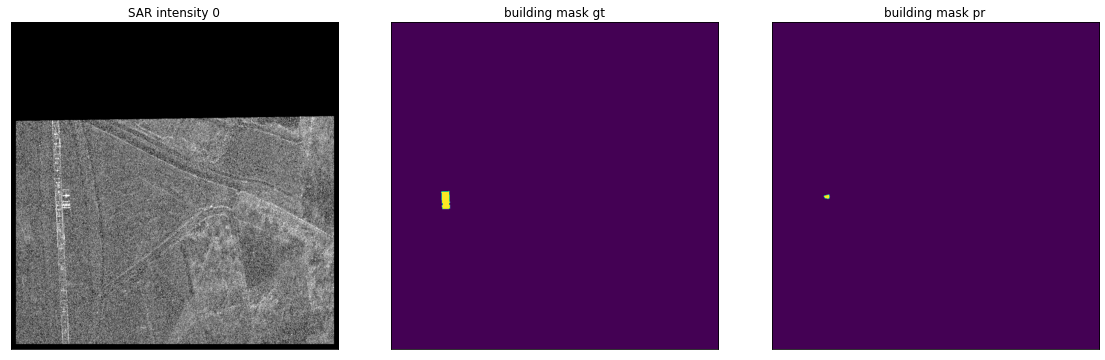

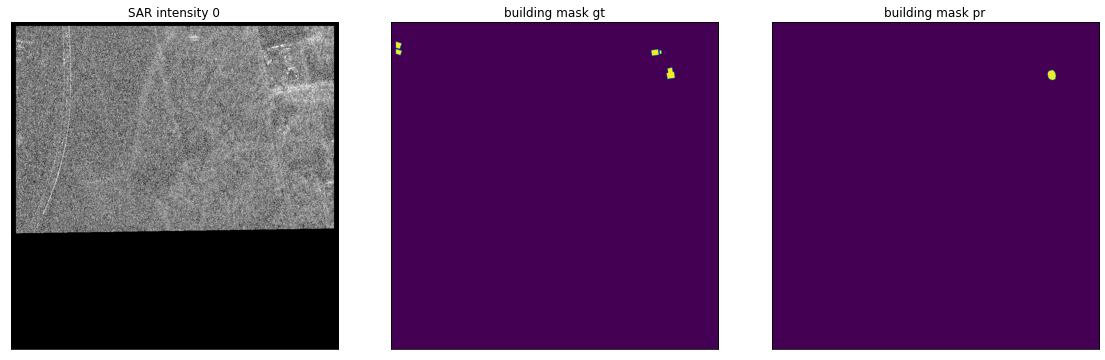

In [7]:
score_thresh = 0.5
alpha = 1.0

start_index = 200
N = 16

for i in range(start_index, start_index + N):
    image_vis = val_dataset_vis[i][0]
    image, gt_mask = val_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(config.MODEL.DEVICE).unsqueeze(0)
    pr_score = model.module.predict(x_tensor)
    pr_score = pr_score.squeeze()
    pr_score = (pr_score.squeeze().cpu().numpy())
    
    pr_score_building = compute_building_score(
        pr_score[channel_footprint],
        pr_score[channel_boundary],
        alpha=alpha
    )
    pr_mask = pr_score_building > score_thresh
    
    plot_images(
        SAR_intensity_0=(adjust_sar_contrast(image_vis[:, :, 0]), 'gray'),
        building_mask_gt=(gt_mask[channel_footprint], 'viridis'),
        building_mask_pr=(pr_mask, 'viridis')
    )